# Introduction 

1. **Notebook Description** In this notebook, I implement the Nature Risk Profile methodology. This method, co-developed by S&P Global and UNEP-WCMC, is designed to assess the materiality, relevance, reliance, resilience, and dependency scores related to the provision of ground and surface water. I apply this methodology at various levels: asset, asset group, and company-wide. The three mining companies under examination in this analysis are Freeport-McMoRan Inc, Glencore plc, and BHP Group.
2. **Author** Filippo Radice Fossati
3. **Date** 09/22/2023



# Notebook Structure 

This notebook is structured as follows:

1. **Section 1**: Importing necessary libraries and datasets.
2. **Section 2**: Computation of the Reliance, Resilience, and Dependency scores at the asset level.
3. **Section 3**: Calculation of the Reliance, Resilience, and Dependency scores at the asset type level.
4. **Section 4**: Computation of the Composite Score at the asset type level.
5. **Section 5**: Calculation of the Dependency Score at the company level.

Each section provides an in-depth description of the methodology, assumptions, and steps employed, designed to facilitate understanding of the code.


# Section 1 - Import

## 1.1 - Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import time

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import gmean

import warnings

import osmnx as ox
import geopandas as gpd

import support_function as sf

%load_ext autoreload
%autoreload 2
#to suppress scientifc notation
pd.set_option('display.float_format', '{:.3f}'.format)


## 1.2 - Dataset

In [2]:
#import asset
asset = pd.read_csv('./_data/Asset_Data_v1.csv')
#renaming columns
asset.columns = asset.columns.map(lambda x: '_'.join(x.split(' ')).lower())
asset.head(1)

,data_source,key_id,asset_id,asset_name,asset_id_type,year,country,latitude,longitude,facility_category,...,ultimate_parent_name,ultimate_parent_mi_key,ultimate_parent_ciq_id,ultimate_parent_isin,trucost_uid,ultimate_parent_uid,gics_sector,category,geometry_epsg_8857,geometry_epsg_4326
0,EU NPRI,6377,43558,Nordenhamer Zinkhütte GmbH,EU NPRI,2021,Germany,53.507,8.502,Regulated Industrial Site,...,Glencore plc,4113732,704674,JE00B4T3BW64,123592.000,123592,Diversified Metals & Mining,Asset,"POLYGON ((652946.774964 6331403.598938, 652929...","POLYGON ((8.502672 53.507305, 8.502451 53.5073..."


In [3]:
#import encore materiality
materiality = pd.read_csv("./_data/ENCORE_data/ENCORE dependency materialities.csv")
#renaming columns
materiality.columns = materiality.columns.map(lambda x: '_'.join(x.split(' ')).lower())
materiality.head(1)

,process,ecosystem_service,rating,justification
0,Airport services,Mass stabilisation and erosion control,M,"Although less practical, production process ca..."


In [4]:
#importing universe and cleaning the df
universe = pd.read_csv('./_data/Company_Universe_Data_v1.csv')
universe = universe.iloc[:,:20].copy()
#renaming columns
universe.columns = universe.columns.map(lambda x: '_'.join(x.split(' ')).lower())
universe.head(1)

,tcuid,year,companyname,isin,countrycode,countryname,gicscode,gicsname,gicssectorname,gicsindustrygroupname,gicsindustryname,tc464_primarysectorreference,tc464_primarysectorname,tctotalrevenue,tcebitda,tcebit,tcabswaterdirectcooling,tcabswaterdirectprocess,tcabswaterpurchased,tcabswaterdirectandpurchased
0,42696,2021,Amcor plc,JE00BJ1F3079,CH,SWITZERLAND,15103020,Paper & Plastic Packaging Products & Materials,Materials,Materials,Containers & Packaging,32222A,"Coated and laminated paper, packaging paper an...",12861.000,2002.000,1438.000,0.000,1298900.000,0.000,1298900.000


In [5]:
#import World Resourse Institute Water Risk
wri = pd.read_csv('./_data/wri/baseline/annual/csv/y2019m07d11_aqueduct30_annual_v01.csv')
#renaming columns
wri.columns = wri.columns.map(lambda x: '_'.join(x.split(' ')).lower())
wri.head(1)

/var/folders/kz/gkm958296f79lgmty6dfw0xc0000gn/T/ipykernel_38143/558905749.py:2: DtypeWarning: Columns (12,16,20,24,32,36,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  wri = pd.read_csv('./_data/wri/baseline/annual/csv/y2019m07d11_aqueduct30_annual_v01.csv')


,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_rrr_raw,w_awr_tex_rrr_score,w_awr_tex_rrr_cat,w_awr_tex_rrr_label,w_awr_tex_rrr_weight_fraction,w_awr_tex_tot_raw,w_awr_tex_tot_score,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.224,2.318,...,1.623,2.165,2.000,Medium - High (2-3),0.327,2.457,3.615,3.000,High (3-4),0.878


In [6]:
#import World geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(1)

/var/folders/kz/gkm958296f79lgmty6dfw0xc0000gn/T/ipykernel_38143/1150554899.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.000,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."


In [7]:
#webscraping to create country dataset
# ISO alpha-2 and alpha-3 data
countries = sf.fetch_country_codes()
countries.head(1)

,country_name,iso_3_code
0,Afghanistan,AFG


# Section 2 - Reliance, Resilience And Dependency Score (Asset Level)

## 2.1 - Reliance Score

**Methodology Description**

In order to compute the Reliance Score, the Materiality of the Dependency must be assessed first. This involves several steps:

1. **Asset Categorization and Materiality Assessment** Companies possess a variety of assets, such as sugar refineries, biofuel plants, coal mines, power plants, and more. Each of these asset types has a unique materiality of dependency. The Encore dataset provides materiality ratings for each process. For this stage, two datasets are essential:i) assets, detailing the types and specifics of company assets; and ii) materiality, containing the materiality ratings.The goal is to align each materiality process with its corresponding asset type.
2. **Merging and Score Assignment** After the initial mapping, this data can be integrated with the assets dataset. As a result, every asset will be associated with a specific rating score, ranging from 0 to 1.

For the calculation of the Reliance Score, it is typically derived from the geometric mean of the product of materiality and an adjustment factor known as the "relevance score". However, for the provisioning services of interest, namely ground and surface water, the methodology specifies that this adjustment is not required. Furthermore, since the geometric mean of 'n' at the asset level is the root of 1 (owing to only one score component per ecosystem service), *the reliance score at the asset level directly equates to the materiality score*.

*Assumption*
I did not calculate the reliance score for the following facility category as I assume they have no relation with water risk:  'Instn Address', 'Company Headquarters'

In [8]:
#selecting Unique combination of activity_description that I will use to infer the Encore process
unique_asset_activity = asset[['asset_id_type'
       ,'facility_category'
       , 'activity_description']].drop_duplicates().sort_values(by='asset_id_type')
unique_asset_activity.head()

,asset_id_type,facility_category,activity_description
227,Australian NPRI,Regulated Industrial Site,Oil and Gas Extraction
243,Australian NPRI,Regulated Industrial Site,Other Basic Non-Ferrous Metal Manufacturing
66,Australian NPRI,Regulated Industrial Site,"Copper, Silver, Lead and Zinc Smelting and Ref..."
11,Australian NPRI,Regulated Industrial Site,Coal Mining
67,Australian NPRI,Regulated Industrial Site,Other Non-Metallic Mineral Mining and Quarrying


In [72]:
#Selecting processes materiality only for ground and water service
water_materiality = materiality[(materiality['ecosystem_service']=='Ground water')|
                                      (materiality['ecosystem_service']=='Surface water')].sort_values(by='process')
water_materiality.head(30)

,process,ecosystem_service,rating,justification
1,Airport services,Ground water,M,"Although less practical, production process ca..."
2,Airport services,Surface water,M,"Although less practical, production process ca..."
5,Alcoholic fermentation and distilling,Ground water,VH,Ecosystem service is critical and irreplaceabl...
6,Alcoholic fermentation and distilling,Surface water,VH,Ecosystem service is critical and irreplaceabl...
15,Alumina refining,Ground water,M,"Although less practical, production process ca..."
16,Alumina refining,Surface water,M,"Although less practical, production process ca..."
28,Aquaculture,Surface water,M,Most of the time the production process can ta...
30,Aquaculture,Ground water,VL,Most of the time the production process can ta...
42,Biomass energy production,Ground water,M,Most of the time the production process can ta...
43,Biomass energy production,Surface water,M,Most of the time the production process can ta...


In [10]:
#printing encore processes
water_materiality.process.unique()

array(['Airport services', 'Alcoholic fermentation and distilling',
       'Alumina refining', 'Aquaculture', 'Biomass energy production',
       'Catalytic cracking, fractional distillation and crystallization',
       'Construction', 'Construction materials production',
       'Cruise line provision', 'Cryogenic air separation',
       'Electronics and hardware production',
       'Environmental and facilities services',
       'Freshwater wild-caught fish', 'Gas adsorption',
       'Geothermal energy production', 'Glass making',
       'Hotels and resorts provision',
       'Houseware and specialities production', 'Hydropower production',
       'Incomplete combustion', 'Integrated oil and gas',
       'Iron extraction', 'Iron metal production', 'Jewellery production',
       'Large-scale forestry', 'Large-scale irrigated arable crops',
       'Large-scale livestock (beef and dairy)',
       'Large-scale rainfed arable crops', 'Leisure facility provision',
       'Life science, phar

In [11]:
#printing activity description for assets
unique_asset_activity.activity_description.unique()

array(['Oil and Gas Extraction',
       'Other Basic Non-Ferrous Metal Manufacturing',
       'Copper, Silver, Lead and Zinc Smelting and Refining',
       'Coal Mining', 'Other Non-Metallic Mineral Mining and Quarrying',
       'Railway Rolling Stock Manufacturing and Repair Services',
       'Support activities for crop production',
       'Extraction of crude petroleum and natural gas',
       'Manufacture of refined petroleum products',
       'Treatment and disposal of non-hazardous waste',
       'Manufacture of other chemical products n.e.c.',
       'Extraction of crude petroleum', 'Copper production',
       'Wholesale of solid, liquid and gaseous fuels and related products',
       'Casting of other non-ferrous metals',
       'Manufacture of dyes and pigments', 'Raising of poultry',
       'Lead, zinc and tin production',
       'Manufacture of other inorganic basic chemicals',
       'Other non-ferrous metal production',
       'Manufacture of other organic basic chemicals'

In [12]:
#now there is the need to manualy map activity description with processes
#if I could not map, I will then assign the Mining Process as default
activity_to_process = {
    'Oil and Gas Extraction': 'Oil and gas drilling',
    'Other Basic Non-Ferrous Metal Manufacturing': 'Metal processing',
    'Copper, Silver, Lead and Zinc Smelting and Refining': 'Metal processing',
    'Coal Mining': 'Mining',
    'Other Non-Metallic Mineral Mining and Quarrying': 'Mining',
    'Railway Rolling Stock Manufacturing and Repair Services': 'Railway transportation',
    'Support activities for crop production': 'Small-scale irrigated arable crops',
    'Extraction of crude petroleum and natural gas': 'Oil and gas drilling',
    'Manufacture of refined petroleum products': 'Oil and gas refining',
    'Treatment and disposal of non-hazardous waste': 'Environmental and facilities services',
    'Manufacture of other chemical products n.e.c.': 'Polymerization',
    'Extraction of crude petroleum': 'Oil and gas drilling',
    'Copper production': 'Metal processing',
    'Wholesale of solid, liquid and gaseous fuels and related products': '',
    'Casting of other non-ferrous metals': 'Metal processing',
    'Manufacture of dyes and pigments': '',
    'Raising of poultry': 'Small-scale livestock (beef and dairy)',
    'Lead, zinc and tin production': 'Metal processing',
    'Manufacture of other inorganic basic chemicals': '',
    'Other non-ferrous metal production': 'Metal processing',
    'Manufacture of other organic basic chemicals': 'Polymerization',
    'Asset': '',
    'Ethanol Plant': 'Alcoholic fermentation and distilling',
    'Steel': 'Steel production',
    'Port Terminal': 'Marine ports and services',
    'Electric Plant': 'Nuclear and thermal power stations',
    'Other Industrial': '',
    'Refinery': 'Oil and gas refining',
    'Instn Address': '',
    'Company Headquarters': '',
    'Surface': '',
    'Underground': 'Mining',
    'Facility': '',
    'Mining Property': 'Mining',
    'Power Plant': 'Nuclear and thermal power stations',
    'Sugar production': 'Processed food and drink production',
    'WAT': '',
    'COAL': 'Mining',
    'OIL': 'Oil and gas drilling'
}



In [13]:
#now I am creating the new column and filling null values with Mining as Default
unique_asset_activity['process'] = unique_asset_activity['activity_description'].map(activity_to_process)
unique_asset_activity.replace('','Mining',inplace=True)
unique_asset_activity.head()

,asset_id_type,facility_category,activity_description,process
227,Australian NPRI,Regulated Industrial Site,Oil and Gas Extraction,Oil and gas drilling
243,Australian NPRI,Regulated Industrial Site,Other Basic Non-Ferrous Metal Manufacturing,Metal processing
66,Australian NPRI,Regulated Industrial Site,"Copper, Silver, Lead and Zinc Smelting and Ref...",Metal processing
11,Australian NPRI,Regulated Industrial Site,Coal Mining,Mining
67,Australian NPRI,Regulated Industrial Site,Other Non-Metallic Mineral Mining and Quarrying,Mining


In [14]:
#Now I am merging the water materiality with unique asset activity 
# so every process will have its own activity description that can be used to merge after the asset dataset
asset_materiality_mapping_df = water_materiality.merge(unique_asset_activity)
asset_materiality_mapping_df.sample(2)

,process,ecosystem_service,rating,justification,asset_id_type,facility_category,activity_description
31,Mining,Surface water,H,Ecosystem service is critical and irreplaceabl...,WEPP ID,Power Plants,WAT
55,Oil and gas drilling,Surface water,VL,Most of the time the production process can ta...,WEPP ID,Power Plants,OIL


In [15]:
#I need to trasnlate qualitative materiality rating into quantitative materiality score
rating_to_numeric = {
    'No dependency':0
    , 'VL':.2
    , 'L':.4
    , 'M':.6
    , 'H':.8
    , 'VH':1
    
}
asset_materiality_mapping_df['rating_numeric'] = asset_materiality_mapping_df['rating'].map(rating_to_numeric)
asset_materiality_mapping_df.reset_index(drop=True, inplace=True)
asset_materiality_mapping_df.head(2)

,process,ecosystem_service,rating,justification,asset_id_type,facility_category,activity_description,rating_numeric
0,Alcoholic fermentation and distilling,Ground water,VH,Ecosystem service is critical and irreplaceabl...,"IHS Industrial, Agriculture and Mining",Biofuel Plant,Ethanol Plant,1.000
1,Alcoholic fermentation and distilling,Surface water,VH,Ecosystem service is critical and irreplaceabl...,"IHS Industrial, Agriculture and Mining",Biofuel Plant,Ethanol Plant,1.000


In [16]:
# Filtering out'Instn Address' or 'Company Headquarters' as likely they do not have dependency from water
asset_materiality_mapping_df = asset_materiality_mapping_df.loc[~asset_materiality_mapping_df['facility_category'].isin(['Instn Address', 'Company Headquarters'])]
#making sure they have been filtered out
asset_materiality_mapping_df[asset_materiality_mapping_df['facility_category'].isin(['Instn Address', 'Company Headquarters'])]

,process,ecosystem_service,rating,justification,asset_id_type,facility_category,activity_description,rating_numeric


In [17]:
# Merging Water MAteriality score With asset level data 
water_materiality_ = asset_materiality_mapping_df.merge(asset)
water_materiality_.sample(5)

,process,ecosystem_service,rating,justification,asset_id_type,facility_category,activity_description,rating_numeric,data_source,key_id,...,ultimate_parent_name,ultimate_parent_mi_key,ultimate_parent_ciq_id,ultimate_parent_isin,trucost_uid,ultimate_parent_uid,gics_sector,category,geometry_epsg_8857,geometry_epsg_4326
1111,Mining,Ground water,H,Ecosystem service is critical and irreplaceabl...,KeyMineProject,Mining Property,Mining Property,0.800,S&P Market Intelligence Metals and Mining Prop...,1336601,...,Freeport-McMoRan Inc.,4004107,273607,US35671D8570,43856.000,43856,Copper,Asset,"POLYGON ((-9863853.488645 3989625.884764, -986...","POLYGON ((-111.0023 31.8984, -111.0031 31.9316..."
1077,Mining,Ground water,H,Ecosystem service is critical and irreplaceabl...,KeyMineProject,Mining Property,Mining Property,0.800,S&P Market Intelligence Metals and Mining Prop...,1337327,...,Glencore plc,4113732,704674,JE00B4T3BW64,123592.000,123592,Diversified Metals & Mining,Asset,"POLYGON ((2670126.028408 -3295101.796321, 2670...","POLYGON ((29.29946 -26.10549, 29.299521 -26.10..."
515,Mining,Surface water,H,Ecosystem service is critical and irreplaceabl...,KeyMineProject,Mining Property,Mining Property,0.800,S&P Market Intelligence Metals and Mining Prop...,1337342,...,Glencore plc,4113732,704674,JE00B4T3BW64,123592.000,123592,Diversified Metals & Mining,Asset,"POLYGON ((2684120.402303 -3429984.879753, 2684...","POLYGON ((29.583579 -27.2175, 29.583609 -27.21..."
630,Mining,Surface water,H,Ecosystem service is critical and irreplaceabl...,KeyMineProject,Mining Property,Mining Property,0.800,S&P Market Intelligence Metals and Mining Prop...,1337715,...,BHP Group,4121840,256654,AU000000BHP4,44114.000,44114,Diversified Metals & Mining,Asset,"POLYGON ((12241815.393656 -3816339.070998, 122...","POLYGON ((136.8176 -30.4365, 136.8228 -30.4532..."
1273,Oil and gas drilling,Surface water,VL,Most of the time the production process can ta...,Australian NPRI,Regulated Industrial Site,Oil and Gas Extraction,0.200,Australian NPRI,3690,...,BHP Group,4121840,256654,AU000000BHP4,NaN,44114,Diversified Metals & Mining,Asset,POLYGON EMPTY,POLYGON EMPTY


In [18]:
#let me clean and save off this dataset
columns_to_save = [
    'asset_id_type'
    ,'asset_id'
    , 'key_id'
    , 'gics_sector'
    , 'ultimate_parent_isin'
    , 'ultimate_parent_name'
    , 'country'
    , 'latitude'
    , 'longitude'
    , 'process'
    , 'ecosystem_service'
    , 'rating_numeric'   
    
]
water_materiality = water_materiality_[columns_to_save].copy()
water_materiality.rename(columns={'rating_numeric':'materiality_score'}, inplace=True)
water_materiality.sample(5)

,asset_id_type,asset_id,key_id,gics_sector,ultimate_parent_isin,ultimate_parent_name,country,latitude,longitude,process,ecosystem_service,materiality_score
1091,KeyMineProject,24734,1336608,Copper,US35671D8570,Freeport-McMoRan Inc.,United States of America,32.843,-108.009,Mining,Ground water,0.800
839,KeyMineProject,36658,1337678,Diversified Metals & Mining,AU000000BHP4,BHP Group,Australia,-22.228,119.039,Mining,Ground water,0.800
240,IHS Exploration and Production,2255924,75529,Copper,US35671D8570,Freeport-McMoRan Inc.,United States of America,33.298,-103.694,Mining,Surface water,0.800
217,IHS Exploration and Production,1208636,75518,Copper,US35671D8570,Freeport-McMoRan Inc.,United States of America,34.056,-118.385,Mining,Surface water,0.800
244,IHS Exploration and Production,2257591,75541,Copper,US35671D8570,Freeport-McMoRan Inc.,United States of America,35.310,-96.476,Mining,Surface water,0.800


In [19]:
#converting the pandas dataframe into a geopandas
water_materiality = gpd.GeoDataFrame(
    water_materiality,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(water_materiality['longitude'], water_materiality['latitude'])
)


In [20]:
water_materiality.sample(2)

,asset_id_type,asset_id,key_id,gics_sector,ultimate_parent_isin,ultimate_parent_name,country,latitude,longitude,process,ecosystem_service,materiality_score,geometry
488,KeyMineProject,33397,1337309,Diversified Metals & Mining,JE00B4T3BW64,Glencore plc,Canada,49.623,-77.704,Mining,Surface water,0.800,POINT (-77.70417 49.62278)
993,KeyMineProject,37847,1337322,Diversified Metals & Mining,JE00B4T3BW64,Glencore plc,Colombia,11.018,-72.714,Mining,Ground water,0.800,POINT (-72.71400 11.01800)


## 2.2 - Dependency Score

**Methodology Description**

To ascertain the Dependency Score at the asset level for each ecosystem service, I needed to first compute the Resilience Score. The Resilience Score leverages the water risk framework from the World Resource Institute (WRI), known as Aqueduct.

*Aqueduct Framework Overview*:

1. Indicators: The framework commences with 13 distinct indicators that span various facets of water risk. It encompasses  Physical Quantity elements like baseline water stress, baseline water depletion, and groundwater table decline; Physical Quality metrics such as untreated connected wastewater and coastal eutrophication potential; Regulatory and Reputational indicators like unimproved/no drinking water
 
2. The three broader groups Physical Quality, Physical Quantity and Regulatory and Reputational Risk are synthesized to produce a holistic water risk score utilizing either default, industry-specific, or user-specified weightings.

*Important Assumptions*:
1. Significance of Resilience & Chosen Risk Indicator: Ecosystem resilience is gauged by its enduring capacity to consistently offer indispensable ecosystem services. The indicators aforementioned are believed to influence the ecosystem's provision of ground and surface water services - this includes even the regulatory risks. In addition, the Task-force on Nature Financial Disclosure addresses both the tangible physical risks and the conceptual transition risks. Given these considerations, the overall water risk has been selected as the proxy for ecosystem resilience. This metric remains consistent for both ground and surface water provisioning services. When aggregating the 13 indicators, the WRI offers three distinct weighting methodologies. For the goals of this analysis, I've opted to employ the sector-specific weighting for asset categories that align with WRI's defined sectors.
2. Regionalization of Resilience Score: In risk assessment, it's imperative to pinpoint potential high risks. Thus, when aggregating at the country level, I've chosen to take the maximum risk value. This approach adeptly captures heightened tail risk while simultaneously preserving variation across sectors.


*Calculation Step*
1. Mapping: The initial step involved aligning asset process definitions with the sector classifications provided by WRI. Further, the aggregate risk variable at the sector level was mapped to the sector names as delineated by WRI.

2. Scaling: Scores derived from this dataset span a range from 0 to 5. To tailor these scores for this analysis, the Min-Max Normalization technique was employed. This method upholds the inherent relationships between data points, ensuring the resultant scaled values fall within the [0, 1] range. 

3. Resilience Score Regionalized: The resulting normalized resilience score will then get aggregated at the country level by taking the maximum of value for every sector. 

4. Merging Resilience Score: The resulting regionalized resilience score was then attributed to the corresponding asset level.

5. Dependency Score: The final Dependency Score is obtained by multiplying the resilience by the previously computed materiality. It's worth noting that due to a score component of 1 for each type, the geometric mean of the multiplication mirrors the multiplication result itself.

In [21]:
#Mapping the processes with sectors given by WRI using lists as values
sector_to_process = {
    'food_and_beverage': [
        'Alcoholic fermentation and distilling',
        'Processed food and drink production'
    ],
    'construction_materials': [
        'Environmental and facilities services',
        'Marine ports and services',
        'Railway transportation'
    ],
    'mining': [
        'Metal processing',
        'Mining',
        'Steel production'
    ],
    'oil_and_gas': [
        'Oil and gas drilling',
        'Oil and gas refining'
    ],
    'chemicals': ['Polymerization'],
    'electric_power': ['Nuclear and thermal power stations'],
    'agriculture': ['Small-scale irrigated arable crops'
                   ,'Small-scale livestock (beef and dairy)']
}


In [22]:
# Mapping sector with correct column name
variable_to_sector = {
    'w_awr_fnb_tot_score':'food_and_beverage'
    , 'w_awr_con_tot_score': 'construction_materials'
    , 'w_awr_min_tot_score': 'mining'
    , 'w_awr_ong_tot_score':'oil_and_gas'
    , 'w_awr_che_tot_score': 'chemicals'
    , 'w_awr_elp_tot_score': 'electric_power'
    , 'w_awr_agr_tot_score': 'agriculture'

}


In [23]:
##here I am subselecting the column that I am interested into
#As mentioned in the description above I am selecting only score aggregate sector level 
columns_list_wri = ['string_id'
                    , 'aq30_id', 'pfaf_id', 'gid_1', 'aqid', 'gid_0'
                    , 'name_0','name_1', 'area_km2'
                    , 'w_awr_fnb_tot_score'
                    , 'w_awr_con_tot_score'
                    , 'w_awr_min_tot_score'
                    , 'w_awr_ong_tot_score'
                    , 'w_awr_che_tot_score'
                    , 'w_awr_elp_tot_score'
                    ,'w_awr_agr_tot_score']



wri_ = wri[columns_list_wri].copy()

##removing  value I won't be able to deal with
# Define the values to replace
values_to_remove = ['-9999', -9999.0]
# Replace the values in the entire DataFrame
wri_ = wri_.replace(values_to_remove, np.nan).dropna()
wri_.sample(5)

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,w_awr_fnb_tot_score,w_awr_con_tot_score,w_awr_min_tot_score,w_awr_ong_tot_score,w_awr_che_tot_score,w_awr_elp_tot_score,w_awr_agr_tot_score
58180,773602-USA.29_1-1355,58183,773602.000,USA.29_1,1355.000,USA,United States,Nevada,1872.288,0.746,0.548,0.434,0.304,0.436,0.600,0.759
60616,822934-CAN.1_1-595,60619,822934.000,CAN.1_1,595.000,CAN,Canada,Alberta,3582.920,4.019,3.370,1.347,0.818,1.702,3.947,3.788
6947,142962-MLI.8_1-2018,6947,142962.000,MLI.8_1,2018.000,MLI,Mali,Sikasso,5271.784,2.826,2.854,3.748,4.092,3.269,1.208,2.920
43413,567018-AUS.6_1-2752,43415,567018.000,AUS.6_1,2752.000,AUS,Australia,Northern Territory,3188.631,3.938,3.225,1.152,0.821,1.566,3.639,3.547
59463,811102-CAN.2_1-725,59466,811102.000,CAN.2_1,725.000,CAN,Canada,British Columbia,6741.082,0.491,0.635,0.748,0.411,0.913,0.691,0.592


In [24]:
##Now I want to normalize the columns so they go to a scale that goes from 0 to 1
# List of columns to scale
columns_to_scale = [
    'w_awr_agr_tot_score',
    'w_awr_che_tot_score',
    'w_awr_con_tot_score',
    'w_awr_elp_tot_score',
    'w_awr_fnb_tot_score',
    'w_awr_min_tot_score',
    'w_awr_ong_tot_score'
]

wri_normalized = wri_.copy()
wri_normalized = sf.normalize_columns(wri_normalized,columns_to_scale)
wri_normalized.sample(2)

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,w_awr_fnb_tot_score,w_awr_con_tot_score,w_awr_min_tot_score,w_awr_ong_tot_score,w_awr_che_tot_score,w_awr_elp_tot_score,w_awr_agr_tot_score
6939,142940-MLI.5_1-1978,6939,142940.000,MLI.5_1,1978.000,MLI,Mali,Koulikoro,4964.650,0.912,0.891,0.863,0.863,0.857,0.846,0.902
29177,361033-MNG.10_1-1164,29178,361033.000,MNG.10_1,1164.000,MNG,Mongolia,Govi-Altay,4262.977,0.896,0.886,0.854,0.852,0.855,0.864,0.896


In [25]:
#checking results
wri_normalized[columns_to_scale].describe()

,w_awr_agr_tot_score,w_awr_che_tot_score,w_awr_con_tot_score,w_awr_elp_tot_score,w_awr_fnb_tot_score,w_awr_min_tot_score,w_awr_ong_tot_score
count,51583.000,51583.000,51583.000,51583.000,51583.000,51583.000,51583.000
mean,0.547,0.513,0.517,0.436,0.540,0.531,0.502
std,0.244,0.238,0.249,0.255,0.256,0.259,0.293
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.357,0.321,0.322,0.214,0.340,0.276,0.186
50%,0.538,0.527,0.534,0.353,0.528,0.573,0.544
75%,0.765,0.718,0.725,0.663,0.792,0.776,0.816
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [26]:
#Regionalization of Sector Resilience Score
columns_to_bring_forward = [
    'gid_0',
    'w_awr_agr_tot_score',
    'w_awr_che_tot_score',
    'w_awr_con_tot_score',
    'w_awr_elp_tot_score',
    'w_awr_fnb_tot_score',
    'w_awr_min_tot_score',
    'w_awr_ong_tot_score'
]

wri_normalized_regionalized = wri_normalized[columns_to_bring_forward].copy()

# Using aggregate to apply the max_of_iqr function
wri_normalized_regionalized = wri_normalized_regionalized.groupby('gid_0').max().reset_index()

wri_normalized_regionalized.sample(10)

,gid_0,w_awr_agr_tot_score,w_awr_che_tot_score,w_awr_con_tot_score,w_awr_elp_tot_score,w_awr_fnb_tot_score,w_awr_min_tot_score,w_awr_ong_tot_score
25,BRA,0.910,0.842,0.881,0.848,0.917,0.851,0.876
201,VGB,0.370,0.226,0.218,0.166,0.289,0.202,0.180
123,MLI,0.990,0.916,0.963,0.923,0.987,0.922,0.898
125,MMR,0.864,0.882,0.844,0.682,0.855,0.891,0.911
14,BEN,0.866,0.848,0.853,0.702,0.866,0.866,0.888
122,MKD,0.863,0.799,0.834,0.853,0.863,0.663,0.552
53,EGY,0.978,0.945,0.961,0.989,0.951,0.951,0.939
44,CYP,0.683,0.483,0.647,0.779,0.739,0.390,0.224
175,SUR,0.457,0.835,0.629,0.489,0.435,0.823,0.848
115,LUX,0.565,0.203,0.356,0.482,0.510,0.205,0.126


In [27]:
##Now I would like to melt all these columns so they can be merged after with asset_water dataframe
# Melt the DataFrame while keeping specified columns
wri_normalized_melted = pd.melt(
    wri_normalized_regionalized,
    id_vars='gid_0',
    value_vars=columns_to_scale,
    var_name="resilience_variable",
    value_name="resilience_score"
)
wri_normalized_melted.sample(5)

,gid_0,resilience_variable,resilience_score
1088,BTN,w_awr_min_tot_score,0.683
608,TGO,w_awr_con_tot_score,0.883
264,ECU,w_awr_che_tot_score,0.838
812,SVK,w_awr_elp_tot_score,0.421
396,TGO,w_awr_che_tot_score,0.850


In [28]:
##Now I can create a new column that maps the wri_risk_variable with wri sector and 
# from there mapping sector into processes. 
wri_normalized_melted['wri_sector'] = wri_normalized_melted['resilience_variable'].map(variable_to_sector)
wri_normalized_melted['asset_process'] = wri_normalized_melted['wri_sector'].map(sector_to_process)
#now I can explode it
wri_normalized_melted = wri_normalized_melted.explode('asset_process', ignore_index=True)
wri_normalized_melted.sample(10)

,gid_0,resilience_variable,resilience_score,wri_sector,asset_process
956,LAO,w_awr_con_tot_score,0.807,construction_materials,Railway transportation
167,HRV,w_awr_agr_tot_score,0.457,agriculture,Small-scale livestock (beef and dairy)
443,BHR,w_awr_che_tot_score,0.445,chemicals,Polymerization
2471,TKM,w_awr_min_tot_score,0.920,mining,Steel production
1586,DZA,w_awr_fnb_tot_score,0.945,food_and_beverage,Alcoholic fermentation and distilling
626,VIR,w_awr_che_tot_score,0.312,chemicals,Polymerization
430,ARG,w_awr_che_tot_score,0.867,chemicals,Polymerization
706,BLZ,w_awr_con_tot_score,0.580,construction_materials,Marine ports and services
1302,CAF,w_awr_elp_tot_score,0.866,electric_power,Nuclear and thermal power stations
2510,VEN,w_awr_min_tot_score,0.875,mining,Steel production


In [29]:
#TChecking the process to make sure they are all there
wri_normalized_melted.asset_process.sort_values().unique()

array(['Alcoholic fermentation and distilling',
       'Environmental and facilities services',
       'Marine ports and services', 'Metal processing', 'Mining',
       'Nuclear and thermal power stations', 'Oil and gas drilling',
       'Oil and gas refining', 'Polymerization',
       'Processed food and drink production', 'Railway transportation',
       'Small-scale irrigated arable crops',
       'Small-scale livestock (beef and dairy)', 'Steel production'],
      dtype=object)

In [30]:
#let's check the shape
wri_normalized_melted.shape

(2968, 5)

**Side Note** Originally I was mapping water_materiliaty dataframe with iso_a3 country code through a spatial join with the world dataset. However some values were dropping. For this reason I decided to map country name with ISO Code. This info will allow me to merge the asset reliance score with the country resilience score (present in wri_normalized_melted df), through country iso code and processes.

In [31]:
#printing the country df
countries.sample(2)

,country_name,iso_3_code
78,French Polynesia,PYF
237,Uruguay,URY


In [32]:
#there were few country name spelled differently. Fixing that here.
#and filtering only values required
# cleaning country name
country_list = [x for x in water_materiality.country.sort_values().unique()]
countries_ = countries[countries['country_name'].isin(country_list)].reset_index(drop=True).copy()
#Adding country that havebeen left out given different name convention
iso_data = {
    'country_name': [
        'Democratic Republic of Congo',
        'Netherlands',
        'Philippines',
        'Republic of the Congo',
        'Tanzania',
        'United Kingdom',
        'United States of America'
    ],
    'iso_3_code': ['COD', 'NLD', 'PHL', 'COD', 'TZA', 'GBR', 'USA']
}

iso_df = pd.DataFrame(iso_data)

# Append the new DataFrame to the existing countries_ DataFrame
countries_df = pd.concat([countries_, iso_df]).copy()
#checking the lenght
len(countries_df),len(water_materiality.country.sort_values().unique())

(34, 34)

In [33]:
#creating the water materiality with iso code
water_materiality_iso = water_materiality.merge(countries_df, left_on='country', right_on='country_name').drop(columns='country')
water_materiality_iso.sample()

,asset_id_type,asset_id,key_id,gics_sector,ultimate_parent_isin,ultimate_parent_name,latitude,longitude,process,ecosystem_service,materiality_score,geometry,country_name,iso_3_code
330,KeyMineProject,61732,1337708,Diversified Metals & Mining,AU000000BHP4,BHP Group,-30.446,136.863,Mining,Surface water,0.800,POINT (136.86300 -30.44600),Australia,AUS


In [34]:
##lastly we can merge it with wri_normalized_melted
water_materiality_resilience = water_materiality_iso.merge(wri_normalized_melted
                                  , left_on=['iso_3_code','process']
                                  , right_on=['gid_0','asset_process'])
water_materiality_resilience.sample(5)

,asset_id_type,asset_id,key_id,gics_sector,ultimate_parent_isin,ultimate_parent_name,latitude,longitude,process,ecosystem_service,materiality_score,geometry,country_name,iso_3_code,gid_0,resilience_variable,resilience_score,wri_sector,asset_process
312,KeyMineProject,61368,1337704,Diversified Metals & Mining,AU000000BHP4,BHP Group,-30.875,121.484,Mining,Surface water,0.800,POINT (121.48400 -30.87500),Australia,AUS,AUS,w_awr_min_tot_score,0.545,mining,Mining
392,KeyMineProject,70048,1337703,Diversified Metals & Mining,AU000000BHP4,BHP Group,-21.805,147.984,Mining,Surface water,0.800,POINT (147.98450 -21.80490),Australia,AUS,AUS,w_awr_min_tot_score,0.545,mining,Mining
654,IHS Exploration and Production,1201867,75514,Copper,US35671D8570,Freeport-McMoRan Inc.,40.230,-102.529,Mining,Surface water,0.800,POINT (-102.52930 40.22963),United States of America,USA,USA,w_awr_min_tot_score,0.764,mining,Mining
608,EU NPRI,43558,6377,Diversified Metals & Mining,JE00B4T3BW64,Glencore plc,53.507,8.502,Metal processing,Ground water,0.600,POINT (8.50231 53.50726),Germany,DEU,DEU,w_awr_min_tot_score,0.457,mining,Metal processing
488,KeyMineProject,76091,1337710,Diversified Metals & Mining,AU000000BHP4,BHP Group,-30.446,136.863,Mining,Ground water,0.800,POINT (136.86333 -30.44645),Australia,AUS,AUS,w_awr_min_tot_score,0.545,mining,Mining


**Dependency Score Asset Level** Because I am calculating the dependency at the asset level, for now I can simply multiply the materiality score with resilience score. When I will aggregate them at the asset subgroup level I will use the geometric mean. 

In [35]:
water_materiality_resilience['dependency_score'] = (
    water_materiality_resilience['resilience_score'] *
    water_materiality_resilience['materiality_score']
)

In [36]:
#checking results
water_materiality_resilience.sample(5)

,asset_id_type,asset_id,key_id,gics_sector,ultimate_parent_isin,ultimate_parent_name,latitude,longitude,process,ecosystem_service,materiality_score,geometry,country_name,iso_3_code,gid_0,resilience_variable,resilience_score,wri_sector,asset_process,dependency_score
589,EU NPRI,7505,19167,Diversified Metals & Mining,JE00B4T3BW64,Glencore plc,39.215,8.414,Metal processing,Ground water,0.600,POINT (8.41417 39.21472),Italy,ITA,ITA,w_awr_min_tot_score,0.597,mining,Metal processing,0.358
330,KeyMineProject,61732,1337708,Diversified Metals & Mining,AU000000BHP4,BHP Group,-30.446,136.863,Mining,Surface water,0.800,POINT (136.86300 -30.44600),Australia,AUS,AUS,w_awr_min_tot_score,0.545,mining,Mining,0.436
666,IHS Exploration and Production,2257696,75550,Copper,US35671D8570,Freeport-McMoRan Inc.,34.611,-120.730,Mining,Surface water,0.800,POINT (-120.73030 34.61053),United States of America,USA,USA,w_awr_min_tot_score,0.764,mining,Mining,0.611
637,EU NPRI,5689,24775,Copper,US35671D8570,Freeport-McMoRan Inc.,51.884,4.249,Mining,Ground water,0.800,POINT (4.24871 51.88374),Netherlands,NLD,NLD,w_awr_min_tot_score,0.382,mining,Mining,0.306
444,KeyMineProject,37724,1337681,Diversified Metals & Mining,AU000000BHP4,BHP Group,-27.057,120.448,Mining,Ground water,0.800,POINT (120.44782 -27.05747),Australia,AUS,AUS,w_awr_min_tot_score,0.545,mining,Mining,0.436


In [37]:
water_materiality_resilience['resilience_score'].describe()

count   1390.000
mean       0.702
std        0.168
min        0.148
25%        0.545
50%        0.764
75%        0.839
max        0.997
Name: resilience_score, dtype: float64

In [38]:
#saving off results for visualization in 3. EDA_asset_water
water_materiality_resilience.to_csv('./_data/asset_level_dependency_score.csv',index=False)

# Section 3 - Reliance, Resilience And Dependency Score (Asset Type Level)

In this section, I calculate the resilience_score, materiality_score and dependency_score for each asset group, classified based on their ultimate_parent_isin and process.

Steps:

1. Separating Dataset: I begin by splitting the water_materiality_resilience dataset into two distinct subsets: one focused on groundwater services and the other on surface water services. Each subset contains values for both materiality (which corresponds to reliance) and resilience at the asset level.
2. Score Calculation: in each dataset, we multiply the resilience and reliance scores. While performing this multiplication, the geometric mean is applied, and the results are aggregated by both the ultimate_parent_isin and process levels.
3. Merging Datasets: The datasets from the previous step, representing groundwater and surface water services respectively, are then merged. The combined result forms a single dataset, termed all_scores_water.


In [39]:
#defining my df for calculation
#dependency score is not needed now as needs to be recomputed
columns_list = ['ultimate_parent_isin','process','materiality_score','resilience_score']
ground_water = water_materiality_resilience[water_materiality_resilience['ecosystem_service']=='Ground water'][columns_list] 
surface_water = water_materiality_resilience[water_materiality_resilience['ecosystem_service']=='Surface water'][columns_list]

In [40]:
#printing them out
ground_water.head(1)

,ultimate_parent_isin,process,materiality_score,resilience_score
0,JE00B4T3BW64,Alcoholic fermentation and distilling,1.000,0.917


In [41]:
surface_water.head(1)

,ultimate_parent_isin,process,materiality_score,resilience_score
2,JE00B4T3BW64,Alcoholic fermentation and distilling,1.000,0.917


In [42]:
## Calculating Resilience And Materiality
# Group by 'ultimate_parent_isin' and 'process', and apply the geometric mean 
# to the 'resilience_score' and 'materiality_score' columns
ground_water_gmean = ground_water.groupby(['ultimate_parent_isin', 'process']).agg({
    'resilience_score': sf.geometric_mean,
    'materiality_score': sf.geometric_mean
})

surface_water_gmean = surface_water.groupby(['ultimate_parent_isin', 'process']).agg({
    'resilience_score': sf.geometric_mean,
    'materiality_score': sf.geometric_mean
})
surface_water_gmean.columns = ['surface_water_'+x for x in surface_water_gmean.columns]
ground_water_gmean.columns = ['ground_water_'+x for x in ground_water_gmean.columns]

In [43]:
ground_water_gmean

ground_water_resilience_score  \
ultimate_parent_isin process                                                                 
AU000000BHP4         Marine ports and services                                       0.657   
                     Metal processing                                                0.545   
                     Mining                                                          0.616   
                     Nuclear and thermal power stations                              0.830   
                     Oil and gas drilling                                            0.338   
                     Railway transportation                                          0.827   
                     Steel production                                                0.545   
JE00B4T3BW64         Alcoholic fermentation and distilling                           0.917   
                     Environmental and facilities services                           0.705   
                     Marine ports and services                                       0.808   
                     Metal processing                                                0.489   
                     Mining                                                          0.672   
                     Nuclear and thermal power stations                              0.860   
                     Oil and gas drilling                                            0.853   
                     Oil and gas refining                                            0.453   
                     Polymerization                                                  0.562   
                     Processed food and drink production                             0.917   
                     Small-scale irrigated arable crops                              0.851   
                     Small-scale livestock (beef and dairy)                          0.631   
US35671D8570         Marine ports and services                                       0.705   
                     Metal processing                                                0.617   
                     Mining                                                          0.758   
                     Nuclear and thermal power stations                              0.875   
                     Small-scale livestock (beef and dairy)                          0.631   

                                                             ground_water_materiality_score  
ultimate_parent_isin process                                                                 
AU000000BHP4         Marine ports and services                                        0.800  
                     Metal processing                                                 0.600  
                     Mining                                                           0.800  
                     Nuclear and thermal power stations                               0.600  
                     Oil and gas drilling                                             0.200  
                     Railway transportation                                           0.600  
                     Steel production                                                 0.600  
JE00B4T3BW64         Alcoholic fermentation and distilling                            1.000  
                     Environmental and facilities services                            0.200  
                     Marine ports and services                                        0.800  
                     Metal processing                                                 0.600  
                     Mining                                                           0.800  
                     Nuclear and thermal power stations                               0.600  
                     Oil and gas drilling                                             0.200  
                     Oil and gas refining                                             0.400  
                  

In [44]:
surface_water_gmean

surface_water_resilience_score  \
ultimate_parent_isin process                                                                  
AU000000BHP4         Marine ports and services                                        0.657   
                     Metal processing                                                 0.545   
                     Mining                                                           0.616   
                     Nuclear and thermal power stations                               0.830   
                     Oil and gas drilling                                             0.338   
                     Railway transportation                                           0.827   
                     Steel production                                                 0.545   
JE00B4T3BW64         Alcoholic fermentation and distilling                            0.917   
                     Environmental and facilities services                            0.705   
                     Marine ports and services                                        0.808   
                     Metal processing                                                 0.489   
                     Mining                                                           0.672   
                     Nuclear and thermal power stations                               0.860   
                     Oil and gas drilling                                             0.853   
                     Oil and gas refining                                             0.453   
                     Polymerization                                                   0.562   
                     Processed food and drink production                              0.917   
                     Small-scale irrigated arable crops                               0.851   
                     Small-scale livestock (beef and dairy)                           0.631   
US35671D8570         Marine ports and services                                        0.705   
                     Metal processing                                                 0.617   
                     Mining                                                           0.758   
                     Nuclear and thermal power stations                               0.875   
                     Small-scale livestock (beef and dairy)                           0.631   

                                                             surface_water_materiality_score  
ultimate_parent_isin process                                                                  
AU000000BHP4         Marine ports and services                                         0.800  
                     Metal processing                                                  0.600  
                     Mining                                                            0.800  
                     Nuclear and thermal power stations                                1.000  
                     Oil and gas drilling                                              0.200  
                     Railway transportation                                            0.600  
                     Steel production                                                  0.600  
JE00B4T3BW64         Alcoholic fermentation and distilling                             1.000  
                     Environmental and facilities services                             0.200  
                     Marine ports and services                                         0.800  
                     Metal processing                                                  0.600  
                     Mining                                                            0.800  
                     Nuclear and thermal power stations                                1.000  
                     Oil and gas drilling                                              0.200  
                     Oil and gas refining                             

In [45]:
## Calculating Dependency Score at the subgroup level. Even in this case I can simply multiply as n = 1
ground_water_gmean['ground_water_dependency_score'] = (
    ground_water_gmean['ground_water_resilience_score'] *
    ground_water_gmean['ground_water_materiality_score']

)
## Calculating Dependency Score at the subgroup level. Even in this case I can simply multiply as n = 1
surface_water_gmean['surface_water_dependency_score'] = (
    surface_water_gmean['surface_water_resilience_score'] *
    surface_water_gmean['surface_water_materiality_score']

)

In [46]:
ground_water_gmean

ground_water_resilience_score  \
ultimate_parent_isin process                                                                 
AU000000BHP4         Marine ports and services                                       0.657   
                     Metal processing                                                0.545   
                     Mining                                                          0.616   
                     Nuclear and thermal power stations                              0.830   
                     Oil and gas drilling                                            0.338   
                     Railway transportation                                          0.827   
                     Steel production                                                0.545   
JE00B4T3BW64         Alcoholic fermentation and distilling                           0.917   
                     Environmental and facilities services                           0.705   
                     Marine ports and services                                       0.808   
                     Metal processing                                                0.489   
                     Mining                                                          0.672   
                     Nuclear and thermal power stations                              0.860   
                     Oil and gas drilling                                            0.853   
                     Oil and gas refining                                            0.453   
                     Polymerization                                                  0.562   
                     Processed food and drink production                             0.917   
                     Small-scale irrigated arable crops                              0.851   
                     Small-scale livestock (beef and dairy)                          0.631   
US35671D8570         Marine ports and services                                       0.705   
                     Metal processing                                                0.617   
                     Mining                                                          0.758   
                     Nuclear and thermal power stations                              0.875   
                     Small-scale livestock (beef and dairy)                          0.631   

                                                             ground_water_materiality_score  \
ultimate_parent_isin process                                                                  
AU000000BHP4         Marine ports and services                                        0.800   
                     Metal processing                                                 0.600   
                     Mining                                                           0.800   
                     Nuclear and thermal power stations                               0.600   
                     Oil and gas drilling                                             0.200   
                     Railway transportation                                           0.600   
                     Steel production                                                 0.600   
JE00B4T3BW64         Alcoholic fermentation and distilling                            1.000   
                     Environmental and facilities services                            0.200   
                     Marine ports and services                                        0.800   
                     Metal processing                                                 0.600   
                     Mining                                                           0.800   
                     Nuclear and thermal power stations                               0.600   
                     Oil and gas drilling                                             0.200   
                     Oil and gas refining                                             0.400   
 

In [47]:
surface_water_gmean

surface_water_resilience_score  \
ultimate_parent_isin process                                                                  
AU000000BHP4         Marine ports and services                                        0.657   
                     Metal processing                                                 0.545   
                     Mining                                                           0.616   
                     Nuclear and thermal power stations                               0.830   
                     Oil and gas drilling                                             0.338   
                     Railway transportation                                           0.827   
                     Steel production                                                 0.545   
JE00B4T3BW64         Alcoholic fermentation and distilling                            0.917   
                     Environmental and facilities services                            0.705   
                     Marine ports and services                                        0.808   
                     Metal processing                                                 0.489   
                     Mining                                                           0.672   
                     Nuclear and thermal power stations                               0.860   
                     Oil and gas drilling                                             0.853   
                     Oil and gas refining                                             0.453   
                     Polymerization                                                   0.562   
                     Processed food and drink production                              0.917   
                     Small-scale irrigated arable crops                               0.851   
                     Small-scale livestock (beef and dairy)                           0.631   
US35671D8570         Marine ports and services                                        0.705   
                     Metal processing                                                 0.617   
                     Mining                                                           0.758   
                     Nuclear and thermal power stations                               0.875   
                     Small-scale livestock (beef and dairy)                           0.631   

                                                             surface_water_materiality_score  \
ultimate_parent_isin process                                                                   
AU000000BHP4         Marine ports and services                                         0.800   
                     Metal processing                                                  0.600   
                     Mining                                                            0.800   
                     Nuclear and thermal power stations                                1.000   
                     Oil and gas drilling                                              0.200   
                     Railway transportation                                            0.600   
                     Steel production                                                  0.600   
JE00B4T3BW64         Alcoholic fermentation and distilling                             1.000   
                     Environmental and facilities services                             0.200   
                     Marine ports and services                                         0.800   
                     Metal processing                                                  0.600   
                     Mining                                                            0.800   
                     Nuclear and thermal power stations                                1.000   
                     Oil and gas drilling                                              0.200   
                     Oil and gas refining             

In [48]:
##Combining the above dataset
all_scores_water = surface_water_gmean.merge(ground_water_gmean, left_index=True, right_index=True)
all_scores_water

surface_water_resilience_score  \
ultimate_parent_isin process                                                                  
AU000000BHP4         Marine ports and services                                        0.657   
                     Metal processing                                                 0.545   
                     Mining                                                           0.616   
                     Nuclear and thermal power stations                               0.830   
                     Oil and gas drilling                                             0.338   
                     Railway transportation                                           0.827   
                     Steel production                                                 0.545   
JE00B4T3BW64         Alcoholic fermentation and distilling                            0.917   
                     Environmental and facilities services                            0.705   
                     Marine ports and services                                        0.808   
                     Metal processing                                                 0.489   
                     Mining                                                           0.672   
                     Nuclear and thermal power stations                               0.860   
                     Oil and gas drilling                                             0.853   
                     Oil and gas refining                                             0.453   
                     Polymerization                                                   0.562   
                     Processed food and drink production                              0.917   
                     Small-scale irrigated arable crops                               0.851   
                     Small-scale livestock (beef and dairy)                           0.631   
US35671D8570         Marine ports and services                                        0.705   
                     Metal processing                                                 0.617   
                     Mining                                                           0.758   
                     Nuclear and thermal power stations                               0.875   
                     Small-scale livestock (beef and dairy)                           0.631   

                                                             surface_water_materiality_score  \
ultimate_parent_isin process                                                                   
AU000000BHP4         Marine ports and services                                         0.800   
                     Metal processing                                                  0.600   
                     Mining                                                            0.800   
                     Nuclear and thermal power stations                                1.000   
                     Oil and gas drilling                                              0.200   
                     Railway transportation                                            0.600   
                     Steel production                                                  0.600   
JE00B4T3BW64         Alcoholic fermentation and distilling                             1.000   
                     Environmental and facilities services                             0.200   
                     Marine ports and services                                         0.800   
                     Metal processing                                                  0.600   
                     Mining                                                            0.800   
                     Nuclear and thermal power stations                                1.000   
                     Oil and gas drilling                                              0.200   
                     Oil and gas refining             

# Section 4 - Composite Score (Asset Type Level)

**Ecosystem Service Dependency Risk Assessment**

Businesses that heavily rely on a few ecosystem services are at greater risk than those with diversified dependencies. This is akin to putting "all one's eggs in a single basket." If a critical service fails or is compromised, it can have significant repercussions for a business. Conversely, businesses that spread out their dependencies across multiple ecosystem services have a safety net, as the failure of one service might be mitigated by the others.

To quantify this relationship, The Nature Risk Methodology uses a logarithmic function. Logarithms inherently capture the concept of diminishing returns — the initial dependencies introduce substantial risk, but each additional dependency contributes progressively less to the overall risk.

Our measure, the "Ecosystem Service Dependency Score," ranges between 0 (no risk) and 1 (maximum risk). This score is derived from the combined dependency values of different services. A logarithmic transformation ensures that a high dependency on fewer services results in a score closer to 1, indicating higher risk.

In the formula below I added 1 to ensure that:
1. The logarithmic transformation can be applied even when the sum of dependencies is zero (as the logarithm of zero is undefined).
2. The transformation is always in the positive domain, reflecting increasing risk as the dependency score increases.

In [49]:
# Compute composite score
all_scores_water['composite_score'] = np.log(1 + all_scores_water['surface_water_dependency_score'] + 
                                             all_scores_water['ground_water_dependency_score'])
all_scores_water.head(10)

surface_water_resilience_score  \
ultimate_parent_isin process                                                                 
AU000000BHP4         Marine ports and services                                       0.657   
                     Metal processing                                                0.545   
                     Mining                                                          0.616   
                     Nuclear and thermal power stations                              0.830   
                     Oil and gas drilling                                            0.338   
                     Railway transportation                                          0.827   
                     Steel production                                                0.545   
JE00B4T3BW64         Alcoholic fermentation and distilling                           0.917   
                     Environmental and facilities services                           0.705   
                     Marine ports and services                                       0.808   

                                                            surface_water_materiality_score  \
ultimate_parent_isin process                                                                  
AU000000BHP4         Marine ports and services                                        0.800   
                     Metal processing                                                 0.600   
                     Mining                                                           0.800   
                     Nuclear and thermal power stations                               1.000   
                     Oil and gas drilling                                             0.200   
                     Railway transportation                                           0.600   
                     Steel production                                                 0.600   
JE00B4T3BW64         Alcoholic fermentation and distilling                            1.000   
                     Environmental and facilities services                            0.200   
                     Marine ports and services                                        0.800   

                                                            surface_water_dependency_score  \
ultimate_parent_isin process                                                                 
AU000000BHP4         Marine ports and services                                       0.525   
                     Metal processing                                                0.327   
                     Mining                                                          0.493   
                     Nuclear and thermal power stations                              0.830   
                     Oil and gas drilling                                            0.068   
                     Railway transportation                                          0.496   
                     Steel production                                                0.327   
JE00B4T3BW64         Alcoholic fermentation and distilling                           0.917   
                     Environmental and facilities services                           0.141   
                     Marine ports and services                                       0.647   

                                                            ground_water_resilience_score  \
ultimate_parent_isin process                                                                
AU000000BHP4         Marine ports and services                                      0.657   
                     Metal processing                                               0.545   
                     Mining                                                         0.616   
                     Nuclear and thermal power stations                             0.830   
                     Oil and gas drilling                                           0.338   
          

In [50]:
#saving off dataset
all_scores_water.to_csv('./_data/all_scores_asset_type.csv')

# Section 5 - Dependency Score At The Company Level

To aggregate the composite score at the company level, I aim to determine the appropriate weight for each sub-asset group. The reason for this weighting is to account for the varying impact each process has on ground and surface water services. The Universe dataset provides financial metrics such as turnover and water consumption at the sector level, which can be leveraged to assess the intensity of impact each sector has on these ecosystem services. The granularity of the GICS sector name allows it to be mapped back to asset group processes. Therefore, the following steps are performed to compute the aggregate score:

1. **Mapping Process to GICS Name**: Create a new column in all_scores_water that maps each process to its corresponding GICS name.
2. **Water Intensity Metric**: After I calculated company annual total water abstraction I divided it by company total revenue to generate a water intensity metrics to derive asset process level water usage.
3. **Calculating Water Intensity Metric at GICS level**: Group the Universe dataset by year and gicsname, take the max value and then calculate the average of the water intensity metric for all years. 
4. **Merging and Weights Defintion**: the water intensity value at gics level is then associate at the asset group level. With a normalization logic I can then create and assign weights
5. **Calculating Aggregate Score**: Multiply the composite_score by the newly created weights and sum them up at the ISIN level to get the aggregate score for each company.

By following these steps, we can generate a comprehensive, weighted composite score that takes into account both the ecosystem dependency and financial metrics of each sector.

**Assumptions**

1. **Missing Values**: To compute the intensity metric, I opt to use 1) **Total Revenue** as it is less subject to accounting adjustments and provides a straightforward representation of a company's operational scale. ii) **total company water abstraction**. Upon examination, it appears that by subtracting "company annual water purchased for cooling" and "company annual water abstraction for its own process" from the "company annual water abstraction and purchase" variable, we can estimate the value for "company annual water abstraction for cooling," which is missing in approximately ~96% of the dataset. Once this estimate is obtained, it will be summed back to "company annual water abstraction for its own process" to derive the *total company water abstraction*. This total will serve as the numerator in calculating the final water intensity metric. Another issue is that the variable tcabswaterdirectprocess used to compute water intensity metric still contains ~40% of null value. Instead of just taking an average or another simple measure to replace the missing value, it looks at the relationships between the variable with missing data and other variables you have. It uses these relationships to make a more educated guess about what the missing value might be.

2. **Conservative Approach** In line with my intent to maintain a conservative approach and capture potential tail risk, I adopted a two-step aggregation method when consolidating water intensity values at the GICS Name level. Firstly, I aggregate by year, selecting the maximum values, and then proceed to average these maximums across all years.



### 5.1 - Mapping Process to GICS NAME

In [51]:
#process to gics name
process_to_gics_name = {
        'Alcoholic fermentation and distilling': 'Distillers & Vintners',
        'Processed food and drink production': 'Packaged Foods & Meats',
        'Environmental and facilities services': 'Environmental & Facilities Services',
        'Marine ports and services': 'Marine Ports & Services',
        'Railway transportation': 'Rail Transportation',
        'Metal processing': 'Metal, Glass & Plastic Containers',
        'Mining': 'Diversified Metals & Mining',
        'Steel production': 'Steel',
        'Oil and gas drilling': 'Oil & Gas Drilling',
        'Oil and gas refining': 'Oil & Gas Refining & Marketing',
        'Polymerization': 'Specialty Chemicals',
        'Nuclear and thermal power stations': 'Electric Utilities',
        'Small-scale irrigated arable crops': 'Agricultural Products & Services',
        'Small-scale livestock (beef and dairy)': 'Packaged Foods & Meats'
}
all_scores_water.sample(2)

,,surface_water_resilience_score,surface_water_materiality_score,surface_water_dependency_score,ground_water_resilience_score,ground_water_materiality_score,ground_water_dependency_score,composite_score
ultimate_parent_isin,process,,,,,,,
US35671D8570,Small-scale livestock (beef and dairy),0.631,1.000,0.631,0.631,1.000,0.631,0.816
AU000000BHP4,Steel production,0.545,0.600,0.327,0.545,0.600,0.327,0.503


In [52]:
all_scores_water_  = all_scores_water.reset_index().copy()
all_scores_water_['gicsname'] = all_scores_water_['process'].map(process_to_gics_name)
all_scores_water_gics = all_scores_water_.set_index(['ultimate_parent_isin','gicsname']).drop(columns='process')
all_scores_water_gics.sample(2)

surface_water_resilience_score  \
ultimate_parent_isin gicsname                                                      
JE00B4T3BW64         Specialty Chemicals                                   0.562   
                     Diversified Metals & Mining                           0.672   

                                                  surface_water_materiality_score  \
ultimate_parent_isin gicsname                                                       
JE00B4T3BW64         Specialty Chemicals                                    0.400   
                     Diversified Metals & Mining                            0.800   

                                                  surface_water_dependency_score  \
ultimate_parent_isin gicsname                                                      
JE00B4T3BW64         Specialty Chemicals                                   0.225   
                     Diversified Metals & Mining                           0.538   

                                                  ground_water_resilience_score  \
ultimate_parent_isin gicsname                                                     
JE00B4T3BW64         Specialty Chemicals                                  0.562   
                     Diversified Metals & Mining                          0.672   

                                                  ground_water_materiality_score  \
ultimate_parent_isin gicsname                                                      
JE00B4T3BW64         Specialty Chemicals                                   0.400   
                     Diversified Metals & Mining                           0.800   

                                                  ground_water_dependency_score  \
ultimate_parent_isin gicsname                                                     
JE00B4T3BW64         Specialty Chemicals                                  0.225   
                     Diversified Metals & Mining                          0.538   

                                                  composite_score  
ultimate_parent_isin gicsname                                      
JE00B4T3BW64         Specialty Chemicals                    0.371  
                     Diversified Metals & Mining            0.730

### 5.2 - Water Intensity Metric

Steps:
1. Data Imputation: To compute the total water abstraction, it was necessary to impute missing data for the tcabswaterdirectprocess column. For this purpose, I utilized the Iterative Imputer, a method that replaces missing values in a dataset by leveraging information from other variables.
2. Company Water Abstraction: After deriving the annual water abstraction for cooling by the company, this value is then added back to the overall water abstraction for processes.
3. Water Intensity Metric (Company Level): The water intensity metric at the company level is computed by dividing the water intensity metric by the total revenue.
4. Water Intensity Metric (Process/GICS Name Level): The GICS Name provides the most detailed classification that brings us closest to individual company processes. Consequently, I chose to group the dataset by GICS Name and year, select the maximum value, and then calculate the average.

In [53]:
universe.isnull().mean()

tcuid                          0.000
year                           0.000
companyname                    0.000
isin                           0.000
countrycode                    0.000
countryname                    0.000
gicscode                       0.000
gicsname                       0.000
gicssectorname                 0.000
gicsindustrygroupname          0.000
gicsindustryname               0.000
tc464_primarysectorreference   0.000
tc464_primarysectorname        0.000
tctotalrevenue                 0.000
tcebitda                       0.001
tcebit                         0.000
tcabswaterdirectcooling        0.963
tcabswaterdirectprocess        0.407
tcabswaterpurchased            0.000
tcabswaterdirectandpurchased   0.000
dtype: float64

In [54]:
"""
Below I am initializing the Iterative Imputer

The Default estimator is the Bayesian Ridge Regression and I am leaving it as default because:

1. Bayesian Ridge Regression is an extension of linear regression that uses Bayesian inference.

2. It's regularized, meaning it can handle multicollinearity better than standard linear regression. 
Regularization helps prevent overfitting, especially when you have many predictors.

3. It provides a distribution of possible outcomes (water abstraction values in this case) 
rather than a single point estimate. This can give a more nuanced understanding of possible imputed values, 
reflecting the inherent uncertainty in imputation.
4. Bayesian methods inherently account for uncertainty, which might be beneficial 
given that a significant portion of the data is missing  (~40%).

""";

In [55]:
## Create dummy variables and selecting columns required for estimating missing values
dummies_country = pd.get_dummies(universe['countrycode']).astype(int)
#gics sector name instead of gics name for computational time issue
dummies_gics = pd.get_dummies(universe['gicssectorname']).astype(int)

#setting columns I need
columns_needed = [
    'tctotalrevenue'
    , 'tcebitda'
    , 'tcebit'
    , 'tcabswaterdirectcooling'
    , 'tcabswaterdirectprocess'
    , 'tcabswaterpurchased'
    , 'tcabswaterdirectandpurchased'
]

# Concatenate the original DataFrame and the dummy variables
universe_ = pd.concat([universe[columns_needed], dummies_country, dummies_gics], axis=1)
universe_.sample(2)

,tctotalrevenue,tcebitda,tcebit,tcabswaterdirectcooling,tcabswaterdirectprocess,tcabswaterpurchased,tcabswaterdirectandpurchased,AE,AR,AT,...,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
35189,2768.534,4052205.000,3651453.000,NaN,787302.000,0.000,787302.000,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38752,2592.513,271.868,146.216,NaN,441762.365,271036.579,712798.944,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [56]:
## Initialize the imputer

iterative_imputer = IterativeImputer(max_iter=10 # maximum number of iterations to fill null values
                                     , random_state=0 # for replicability
                                    )

# Perform imputation
universe_imputed_arr = iterative_imputer.fit_transform(universe_)

# Convert back to DataFrame
universe_imputed = pd.DataFrame(universe_imputed_arr, columns=universe_.columns)

# Replace the original column with the imputed one
universe['tcabswaterdirectprocess'] = universe_imputed['tcabswaterdirectprocess']

In [57]:
universe.isnull().mean()

tcuid                          0.000
year                           0.000
companyname                    0.000
isin                           0.000
countrycode                    0.000
countryname                    0.000
gicscode                       0.000
gicsname                       0.000
gicssectorname                 0.000
gicsindustrygroupname          0.000
gicsindustryname               0.000
tc464_primarysectorreference   0.000
tc464_primarysectorname        0.000
tctotalrevenue                 0.000
tcebitda                       0.001
tcebit                         0.000
tcabswaterdirectcooling        0.963
tcabswaterdirectprocess        0.000
tcabswaterpurchased            0.000
tcabswaterdirectandpurchased   0.000
dtype: float64

In [58]:
# Calculating Total Company Water Abstraction
# I have to do this for every year
# Calculation of abstraction cooling 
universe['abstraction_cooling'] = universe.apply(
    lambda row: row['tcabswaterdirectandpurchased'] - row['tcabswaterpurchased'] - row['tcabswaterdirectprocess'],
    axis=1
)
#Calculating total abstarction
universe['total_abstraction'] = universe.apply(
    lambda row: row['abstraction_cooling'] + row['tcabswaterdirectprocess'],
    axis=1
)
universe.sample(2)


,tcuid,year,companyname,isin,countrycode,countryname,gicscode,gicsname,gicssectorname,gicsindustrygroupname,...,tc464_primarysectorname,tctotalrevenue,tcebitda,tcebit,tcabswaterdirectcooling,tcabswaterdirectprocess,tcabswaterpurchased,tcabswaterdirectandpurchased,abstraction_cooling,total_abstraction
46186,185266,2020,Coty Inc.,US2220702037,US,UNITED STATES,30302010,Personal Care Products,Consumer Staples,Household & Personal Products,...,Toilet preparation manufacturing ...,4717.800,214.500,-370.200,NaN,776945.236,22290.764,799236.000,0.000,776945.236
36466,43524,2022,Nissan Chemical Corporation,JP3670800006,JP,JAPAN,15101020,Diversified Chemicals,Materials,Materials,...,Plastics material and resin manufacturing ...,1852.194,61182.000,50960.000,NaN,29500000.000,0.000,29500000.000,0.000,29500000.000


In [59]:
#Finally I will be calculating The Water Intensity Metric (m3/USD)
universe['water_intensity'] = universe['total_abstraction']/universe['tctotalrevenue']
universe.sample(2)

,tcuid,year,companyname,isin,countrycode,countryname,gicscode,gicsname,gicssectorname,gicsindustrygroupname,...,tctotalrevenue,tcebitda,tcebit,tcabswaterdirectcooling,tcabswaterdirectprocess,tcabswaterpurchased,tcabswaterdirectandpurchased,abstraction_cooling,total_abstraction,water_intensity
20362,239535,2021,Oncolys BioPharma Inc.,JP3202170001,JP,JAPAN,35201010,Biotechnology,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",...,5.853,-1516.500,-1523.078,NaN,-50027491.507,1671.107,1671.107,50027491.507,0.000,0.000
10501,230272,2019,"XCMG Construction Machinery Co., Ltd.",CNE000000FH0,CN,CHINA,20106010,Construction Machinery & Heavy Transportation ...,Industrials,Capital Goods,...,8273.147,4437.469,3386.101,NaN,3544714.689,920196.295,4464910.984,0.000,3544714.689,428.460


In [60]:
#checking now the distribution of all values calculated
universe.iloc[:,-9:].describe()

,tcebitda,tcebit,tcabswaterdirectcooling,tcabswaterdirectprocess,tcabswaterpurchased,tcabswaterdirectandpurchased,abstraction_cooling,total_abstraction,water_intensity
count,53201.000,53225.000,1984.000,53228.000,53228.000,53228.000,53228.000,53228.000,53228.000
mean,85431.585,62594.872,1058782354.502,2808744.580,1205043.623,63949126.646,59935338.443,62744083.023,20763.072
std,1503694.070,1271345.065,3777305257.589,534455765.932,13634680.502,979040355.901,755422008.873,977394143.684,250986.151
min,-3754966.047,-5903534.000,0.000,-476103741.892,0.000,0.000,-71173857.478,0.000,0.000
25%,73.288,32.219,2247383.747,-50043102.079,13591.332,60454.390,0.000,0.000,0.000
50%,656.220,414.388,62850000.000,48777.318,85962.094,339362.024,0.001,50373.652,178.478
75%,4459.281,2945.000,548250000.000,969745.253,393754.820,1994201.139,50049857.960,1010192.052,1401.597
max,146373200.000,146000000.000,70600000000.000,51200000000.000,1900000000.000,70600000000.000,70594816840.000,70599907840.000,37117750.557


In [61]:
#if I would remove 0 value I would see a substancial drop in coverage
#leave it as it is for now
universe.shape, universe[universe['water_intensity']!=0].shape

((53228, 23), (31228, 23))

In [62]:
#list of sector to use later
list_of_gics = [x for x in all_scores_water_gics.reset_index().gicsname.unique()]

# Filter using list_of_gics
df = universe[universe['gicsname'].isin(list_of_gics)].copy()

# Calculate First the Max for every year at gicsname level and than take the average
universe_water_intensity_year = df.groupby(['year','gicsname'])[['water_intensity']].max().reset_index()
universe_water_intensity = universe_water_intensity_year.groupby('gicsname').mean().sort_values(by='water_intensity').drop(columns='year')
universe_water_intensity

,water_intensity
gicsname,
Oil & Gas Drilling,8696.546
Distillers & Vintners,33139.696
Rail Transportation,48892.566
"Metal, Glass & Plastic Containers",191523.933
Marine Ports & Services,257854.325
Steel,298903.013
Specialty Chemicals,319164.264
Diversified Metals & Mining,779432.964
Oil & Gas Refining & Marketing,841960.635


### 5.3 - Calculate Aggregate Score

To account for the varying impacts across sectors and incorporate this understanding into a comprehensive risk assessment, I employed a multi-stage process:

1. **Merging with Composite Score**: The first step involves merging the sector-level water intensity values with company-level composite scores. This ensures that every company in the dataset has its water intensity value based on its sector.
2. **Normalization**: Once the merger is complete, water intensity values for each company (based on their sector) are normalized to generate individual weights. These weights are indicative of the relative risk each sector poses. A company belonging to a sector with a higher water intensity will be allocated a larger weight, suggesting it has a heightened risk profile due to its sectoral implications.
3. **Weighted Risk Calculation**: For each company, its composite score is then multiplied by its sectoral weight, resulting in a weighted risk score that considers both its individual activities and the broader sectoral risk.
4. **Aggregation**: In the final stage, the weighted risk scores of all companies are aggregated. This aggregated score provides a comprehensive risk assessment that reflects both the individual operations of companies and the overarching implications of the sectors they operate in.

In [63]:
#MErging with Composite Score
composite_score = all_scores_water_gics['composite_score'].reset_index().copy()
composite_score_water_intensity = composite_score.merge(universe_water_intensity.reset_index().copy())
composite_score_water_intensity

,ultimate_parent_isin,gicsname,composite_score,water_intensity
0,AU000000BHP4,Marine Ports & Services,0.718,257854.325
1,JE00B4T3BW64,Marine Ports & Services,0.830,257854.325
2,US35671D8570,Marine Ports & Services,0.755,257854.325
3,AU000000BHP4,"Metal, Glass & Plastic Containers",0.503,191523.933
4,JE00B4T3BW64,"Metal, Glass & Plastic Containers",0.462,191523.933
5,US35671D8570,"Metal, Glass & Plastic Containers",0.554,191523.933
6,AU000000BHP4,Diversified Metals & Mining,0.686,779432.964
7,JE00B4T3BW64,Diversified Metals & Mining,0.730,779432.964
8,US35671D8570,Diversified Metals & Mining,0.794,779432.964
9,AU000000BHP4,Electric Utilities,0.845,7408712.073


In [64]:
# Calculate the total intensity for each ultimate_parent_isin
total_intensities = composite_score_water_intensity.groupby('ultimate_parent_isin')['water_intensity'].transform('sum')

# Create the weights column
composite_score_water_intensity['weights'] = composite_score_water_intensity['water_intensity'] / total_intensities

# If you want to extract the resulting universe with weights, you can now do so:
universe_water_intensity = composite_score_water_intensity.copy()
universe_water_intensity


,ultimate_parent_isin,gicsname,composite_score,water_intensity,weights
0,AU000000BHP4,Marine Ports & Services,0.718,257854.325,0.029
1,JE00B4T3BW64,Marine Ports & Services,0.830,257854.325,0.012
2,US35671D8570,Marine Ports & Services,0.755,257854.325,0.021
3,AU000000BHP4,"Metal, Glass & Plastic Containers",0.503,191523.933,0.021
4,JE00B4T3BW64,"Metal, Glass & Plastic Containers",0.462,191523.933,0.009
5,US35671D8570,"Metal, Glass & Plastic Containers",0.554,191523.933,0.016
6,AU000000BHP4,Diversified Metals & Mining,0.686,779432.964,0.087
7,JE00B4T3BW64,Diversified Metals & Mining,0.730,779432.964,0.037
8,US35671D8570,Diversified Metals & Mining,0.794,779432.964,0.064
9,AU000000BHP4,Electric Utilities,0.845,7408712.073,0.824


In [65]:
#calculating Aggregate Score at the ISIN Level
universe_water_intensity['aggregate_score'] = universe_water_intensity['weights'] * universe_water_intensity['composite_score']
aggregate_score = universe_water_intensity.copy()
aggregate_score = aggregate_score.groupby('ultimate_parent_isin').sum().copy()
aggregate_score = aggregate_score.iloc[:,-2:].copy()
aggregate_score

,weights,aggregate_score
ultimate_parent_isin,,
AU000000BHP4,1.000,0.807
JE00B4T3BW64,1.000,0.799
US35671D8570,1.000,0.846


In [66]:
#saving off dataset
universe_water_intensity.to_csv('./_data/asset_type_weight.csv', index=False)
aggregate_score.to_csv('./_data/aggregate_score.csv')

### Added Post Delivery

In [67]:
universe.columns

Index(['tcuid', 'year', 'companyname', 'isin', 'countrycode', 'countryname',
       'gicscode', 'gicsname', 'gicssectorname', 'gicsindustrygroupname',
       'gicsindustryname', 'tc464_primarysectorreference',
       'tc464_primarysectorname', 'tctotalrevenue', 'tcebitda', 'tcebit',
       'tcabswaterdirectcooling', 'tcabswaterdirectprocess',
       'tcabswaterpurchased', 'tcabswaterdirectandpurchased',
       'abstraction_cooling', 'total_abstraction', 'water_intensity'],
      dtype='object')

In [68]:
company_isin = [x for x in aggregate_score.index]
company_water_intensity = universe[universe['isin'].isin(company_isin)][['year'
                                                                         ,'companyname'
                                                                         ,'tctotalrevenue'
                                                                         ,'total_abstraction'
                                                                         ,'water_intensity']]
company_water_intensity['year'] = pd.to_datetime(company_water_intensity['year'], format='%Y')
company_water_intensity = company_water_intensity.set_index(['year']).sort_index().sort_values(by='companyname')
company_water_intensity

,companyname,tctotalrevenue,total_abstraction,water_intensity
year,,,,
2019-01-01,BHP Group Limited,44288.010,353100000.000,7972.813
2020-01-01,BHP Group Limited,42931.000,380000000.000,8851.413
2021-01-01,BHP Group Limited,61231.000,267000000.000,4360.536
2022-01-01,BHP Group Limited,65411.000,274000000.000,4188.898
2019-01-01,Freeport-McMoRan Inc.,14402.000,266000000.000,18469.657
2020-01-01,Freeport-McMoRan Inc.,14198.000,237400000.000,16720.665
2021-01-01,Freeport-McMoRan Inc.,22845.000,186000000.000,8141.825
2019-01-01,Glencore Plc,215111.000,934000000.000,4341.944
2020-01-01,Glencore Plc,142338.000,916000000.000,6435.386


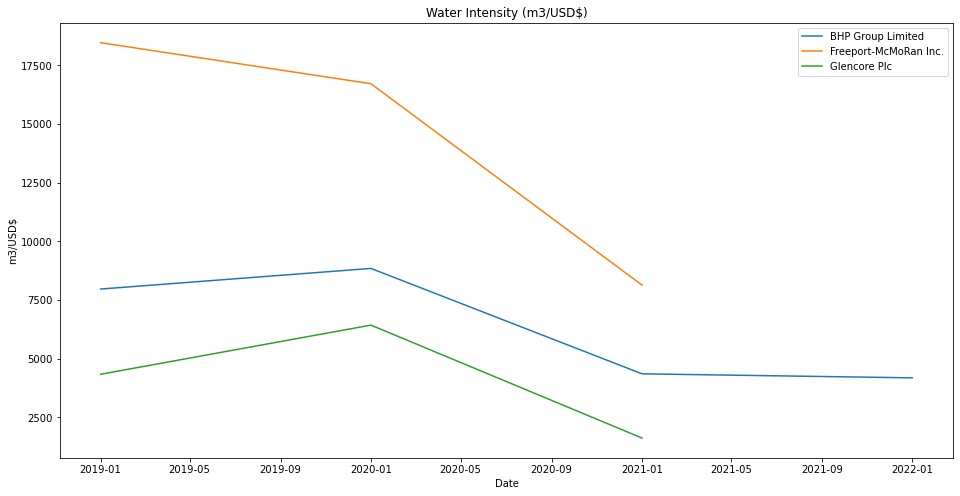

In [69]:
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

groups = company_water_intensity.groupby('companyname')
for name, group in groups:
    plt.plot(group.index.to_numpy(), group['water_intensity'].to_numpy(), label=name)

# Customize the plot (e.g., labels, title, legend)
plt.xlabel('Date')
plt.ylabel('m3/USD$')
plt.title('Water Intensity (m3/USD$)')
plt.legend(loc='best')

# Show the plot
plt.show()

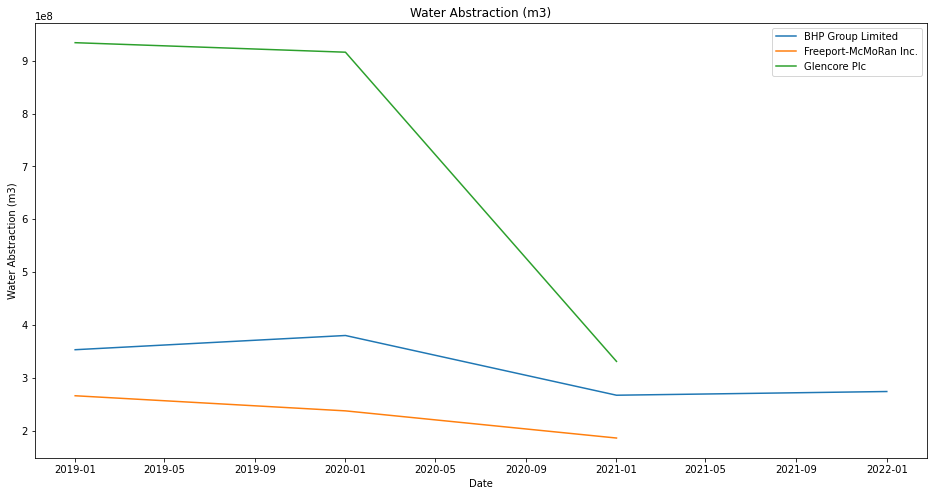

In [70]:
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

groups = company_water_intensity.groupby('companyname')
for name, group in groups:
    plt.plot(group.index.to_numpy(), group['total_abstraction'].to_numpy(), label=name)

# Customize the plot (e.g., labels, title, legend)
plt.xlabel('Date')
plt.ylabel('Water Abstraction (m3)')
plt.title('Water Abstraction (m3)')
plt.legend(loc='best')

# Show the plot
plt.show()

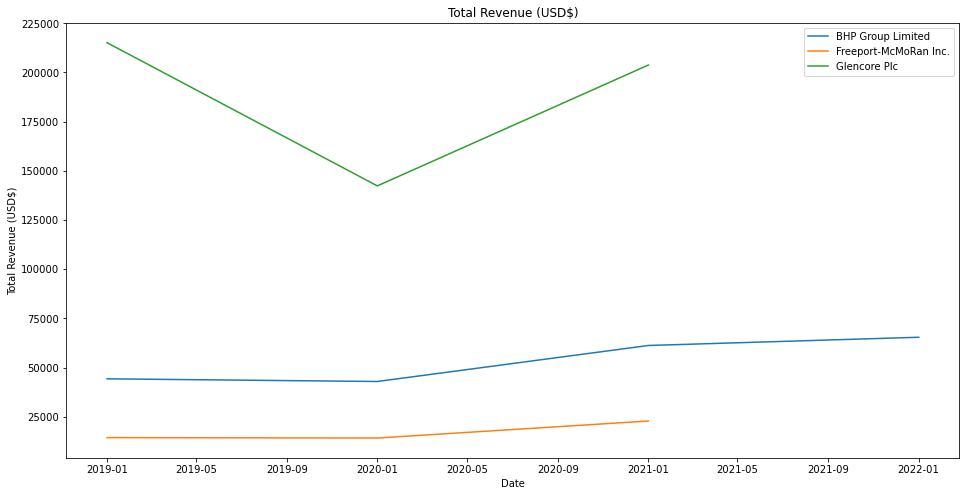

In [71]:
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

groups = company_water_intensity.groupby('companyname')
for name, group in groups:
    plt.plot(group.index.to_numpy(), group['tctotalrevenue'].to_numpy(), label=name)

# Customize the plot (e.g., labels, title, legend)
plt.xlabel('Date')
plt.ylabel('Total Revenue (USD$)')
plt.title('Total Revenue (USD$)')
plt.legend(loc='best')

# Show the plot
plt.show()

In [73]:
company_water_intensity

,companyname,tctotalrevenue,total_abstraction,water_intensity
year,,,,
2019-01-01,BHP Group Limited,44288.010,353100000.000,7972.813
2020-01-01,BHP Group Limited,42931.000,380000000.000,8851.413
2021-01-01,BHP Group Limited,61231.000,267000000.000,4360.536
2022-01-01,BHP Group Limited,65411.000,274000000.000,4188.898
2019-01-01,Freeport-McMoRan Inc.,14402.000,266000000.000,18469.657
2020-01-01,Freeport-McMoRan Inc.,14198.000,237400000.000,16720.665
2021-01-01,Freeport-McMoRan Inc.,22845.000,186000000.000,8141.825
2019-01-01,Glencore Plc,215111.000,934000000.000,4341.944
2020-01-01,Glencore Plc,142338.000,916000000.000,6435.386
